In [20]:
%matplotlib inline
import cv2
import numpy as np
from scipy.sparse import linalg
from util import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from util import *

In [11]:
def load_ply(filename):
    vertices = []
    vertex_count = 0
    header = ''
    line = None
    with open(filename, 'r') as infile:
        while line != 'end_header\n' and line != '':
            line = str(infile.readline())
            header = header + line
        vertices = infile.readlines()
    header = header.split('element face ')[0].split('\n')
    
    for line in header:
        if 'element vertex ' in line:
            vertex_count = int(line.split('element vertex ')[1])
    vertices_arr = []
    for line in vertices[:-1]:
        nums = [np.float32(x) for x in line[:-1].split()]
        vertices_arr.append(nums)
    return np.array(vertices_arr)

Calculate the normal vector and distance from the camera to the laser plane

In [12]:
def compute_pc(filename):
    # Load point cloud
    vertices = load_ply(filename)
    X=vertices
    n = X.shape[0]
    Xm = X.sum(axis=0) / n
    M = np.array(X - Xm).T
    
    # Equivalent to:
    #  numpy.linalg.svd(M)[0][:,2]
    # But 1200x times faster for large point clouds
    U = linalg.svds(M, k=2)[0]
    normal = np.cross(U.T[0], U.T[1])
    if normal[2] < 0:
        normal *= -1

    dist = np.dot(normal, Xm)
    std = np.dot(M.T, normal).std()

    print("\nNormal vector\n\n{0}\n".format(normal))
    print("\nPlane distance\n\n{0} mm\n".format(dist))
    print("\nStandard deviation\n\n{0} mm\n".format(std))
    
    
filename ="/home/isaias/Documents/cylinder.ply"
compute_pc(filename)


Normal vector

[-0.58343244  0.81215852  0.00226401]


Plane distance

4.3732026423108366 mm


Standard deviation

414.51133697765613 mm



Next Step is to calculate the platform calibration in order obtain the rotation matrix and translation vector. The checkerboard image must be moved from 180 degrees from the starting position at increments of 5 degrees.

In [13]:
# Example Points
#Load example points
points = np.array([(-71.889508465627387, 50.013567717607749, 344.49352456998758), (-73.938146681112755, 50.246193674080907, 338.01301804172272), (-75.497351387650639, 50.492948734714403, 330.87542127925065), (-76.376380847308425, 50.734117933168591, 324.17522165185346), (-76.714488167787607, 50.993900582296561, 317.3344047282414), (-76.403768361627812, 51.272234507372353, 309.71864906038684), (-75.485306621272557, 51.549433425353058, 302.68961151070874), (-74.000231775386524, 51.809640767591226, 295.94087917913839), (-71.835845971537935, 52.082778636253131, 289.01220924464218), (-69.311034379453886, 52.328053219713709, 282.87092458439184), (-65.822041224968615, 52.625688337478778, 276.18480478407253), (-62.336253545911951, 52.877250167738936, 270.66679623202765), (-58.041963526078746, 53.137164118260294, 264.97985913318598), (-53.181565932121643, 53.376856358245568, 259.6388616558591), (-48.270518476370661, 53.582888438128002, 255.0205618040097), (-42.173702942476567, 53.798821993651814, 250.33223366723669), (-36.54320409745096, 53.975402416771956, 246.74779748678947), (-30.470855853767048, 54.130827402058607, 243.45798455002659), (-23.565546697472435, 54.289427296325343, 240.58263365325183), (-17.031816562984559, 54.410496232507043, 238.44783394220926), (-10.000560702649052, 54.524867785168766, 236.84255161321303), (-3.024878053643687, 54.612931136574318, 235.84493023779947), (4.1151465080711507, 54.678828047877047, 235.49675611700954), (11.189306930064157, 54.717826806420923, 235.76911469780327)])

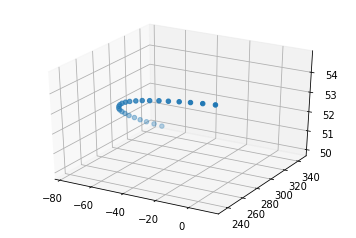

In [14]:
# Plot the example points
fig = plt.figure()
ax = fig.gca(projection='3d')
x, y, z = points.T[0], points.T[1], points.T[2]
ax.scatter(x, z, y)
plt.show()

Fit the plane

In [15]:
def distance2plane(p0, n0, p):
    return np.dot(np.array(n0), np.array(p) - np.array(p0))

def residuals_plane(parameters, data_point):
    px, py, pz, theta, phi = parameters
    nx, ny, nz = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)
    distances = [distance2plane([px, py, pz], [nx, ny, nz], [x, y, z]) for x, y, z in data_point]
    return distances

def fit_plane(data):
    estimate = [0, 0, 0, 0, 0]  # px, py, pz and zeta, phi
    best_fit_values, ier = optimize.leastsq(residuals_plane, estimate, args=(data))
    xF, yF, zF, tF, pF = best_fit_values
    #point  = [xF, yF, zF]
    point = data[0]
    normal = -np.array([np.sin(tF) * np.cos(pF), np.sin(tF) * np.sin(pF), np.cos(tF)])
    return point, normal

point, normal = fit_plane(points)

if normal[1] > 0:
    normal *= -1

print("\nPlane normal\n\n{0}\n".format(normal))


Plane normal

[ 0.0072119  -0.99925488 -0.03791666]



Fit Circle

In [16]:
def residuals_circle(parameters, points, s, r, point):
    r_, s_, Ri = parameters
    plane_point = s_ * s + r_ * r + np.array(point)
    distance = [np.linalg.norm(plane_point - np.array([x, y, z])) for x, y, z in points]
    res = [(Ri - dist) for dist in distance]
    return res

def fit_circle(point, normal, points):
    s = np.cross(np.array([1, 0, 0]), np.array(normal))
    s = s / np.linalg.norm(s)
    r = np.cross(np.array(normal), s)
    r = r / np.linalg.norm(r)

    # Define rotation
    R = np.array([s, r, normal]).T

    estimate_circle = [0, 0, 0]  # px,py,pz and zeta, phi
    best_circle_fit_values, ier = optimize.leastsq(residuals_circle, estimate_circle, args=(points, s, r, point))
    rF, sF, RiF = best_circle_fit_values

    # Synthetic Data
    center_point = sF * s + rF * r + np.array(point)
    synthetic = [list(center_point + RiF * np.cos(phi) * r + RiF * np.sin(phi) * s)
                 for phi in np.linspace(0, 2 * np.pi, 50)]

    return center_point, R

center, R = fit_circle(point, normal, points)

Compute 2d point cloud from laser line and translate it to real world units

In [35]:
import glob
from util import *
impath = "/home/isaias/Pictures/imagesTapeBall/"
imfiles = glob.glob(impath+"*.jpg")
image1 = load_image("/home/isaias/Pictures/imagesTapeBall/image1.jpg")
image2 = load_image("/home/isaias/Pictures/imagesTapeBall/image1_laserOff.jpg")

def r_rgb(image):
    return cv2.split(image)[0]

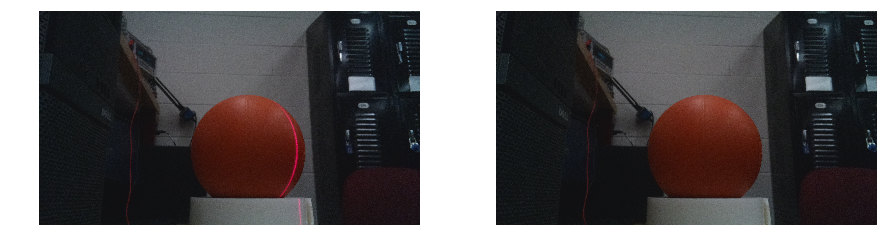

In [36]:
plot_images((image1, image2))

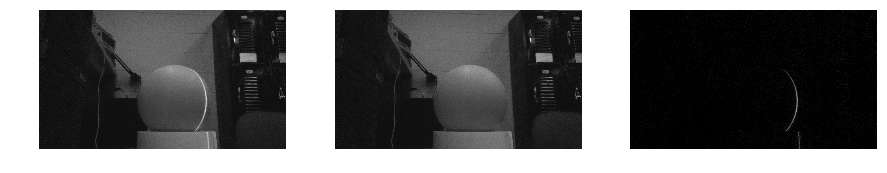

In [38]:
image_r = r_rgb(image1)
image_r_background = r_rgb(image2)

image_diff = cv2.subtract(image_r, image_r_background)
image_diff_r = r_rgb(image_diff)
# UPLOAD TO GOOGLE DRIVE
plot_images((image_r, image_r_background, image_diff_r))

In [ ]:
# Threshold using Sam's Implementation

begin()

for 

In [1]:
# Threshold image using Horus Implementation

begin()

threshold_value = 30
image_threshold = cv2.threshold(image_diff_r, threshold_value, 255, cv2.THRESH_TOZERO)[1]

# Blur image

blur_value = 5
image_blur = cv2.blur(image_threshold, (blur_value, blur_value))

image_blur_threshold = cv2.threshold(image_blur, threshold_value, 255, cv2.THRESH_TOZERO)[1]

end()

plot_images((image_threshold, image_blur_threshold))

NameError: name 'begin' is not defined

Time: 0:00:00.004757


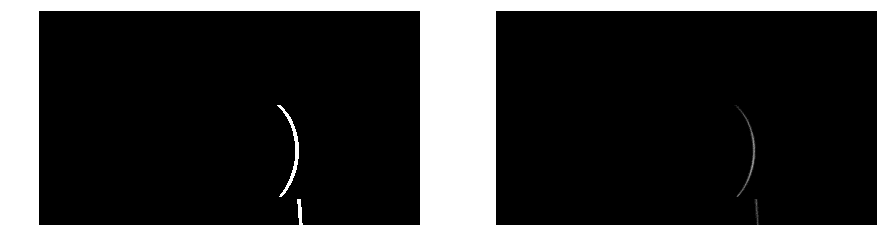

In [46]:
window = 9

begin()

peak = image_blur_threshold.argmax(axis=1)
_min = peak - window
_max = peak + window + 1
mask = np.zeros_like(image_blur_threshold)
for i in range(image_blur_threshold.shape[0]):
    mask[i, _min[i]:_max[i]] = 255

image_stripe = cv2.bitwise_and(image_diff_r, mask)

end()

plot_images((mask, image_stripe))

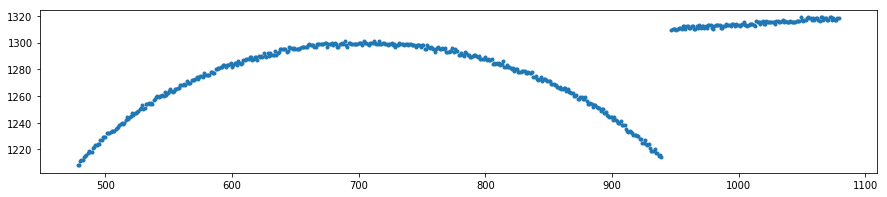

In [47]:
# Compute peak detection

s = image_stripe.sum(axis=1)
v = np.where(s > 0)[0]
peaks = image_stripe.argmax(axis=1)[v]

# Show peak detection
from pylab import rcParams
rcParams['figure.figsize'] = 15,3

plt.plot(v, peaks, '.')
plt.show()

Time: 0:00:00.012061


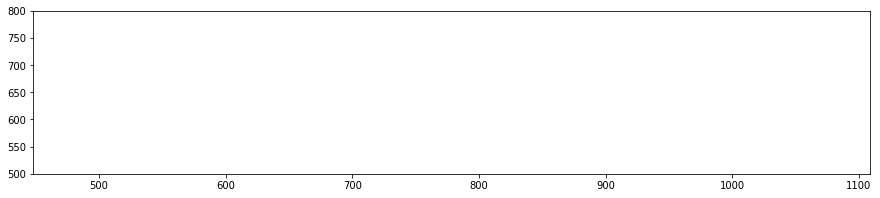

In [48]:


# Compute weight matrix

h, w = image_stripe.shape
weight_matrix = np.array((np.matrix(np.linspace(0, w - 1, w)).T * np.matrix(np.ones(h))).T)

# Compute center of mass

begin()

s = image_stripe.sum(axis=1)
v = np.where(s > 0)[0]
u = (weight_matrix * image_stripe).sum(axis=1)[v] / s[v]

end()

# Show center of mass

pylab.rcParams['figure.figsize'] = (15, 3)
pylab.ylim([500,800])
    
plt.plot(v, u, '.')
plt.show()



In [51]:
# Detect stripe segments

begin()

i = 0
seg = []
segments = [s[_r] for _r in np.ma.clump_unmasked(np.ma.masked_equal(s, 0))]

for segment in segments:
    j = len(segment)
    seg.append(u[i:i+j])
    i += j
    
end()

Time: 0:00:00.000711


Number of segments: 2


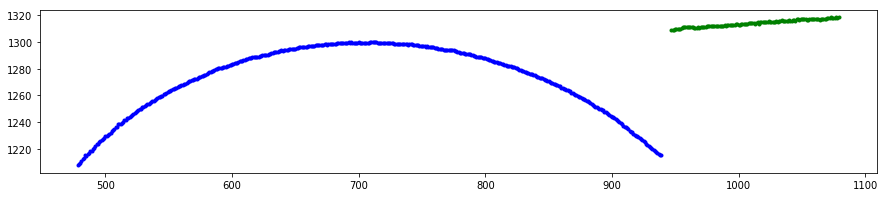

In [57]:
# Show segments

pylab.rcParams['figure.figsize'] = (15, 3)

from itertools import cycle
cycol = cycle('bgrcmk')

i = 0
for segment in segments:
    j = len(segment)
    plt.plot(v[i:i+j], u[i:i+j], '.', color=next(cycol))
    i = i+ j

print('Number of segments: %s' % len(segments))
plt.show()

In [58]:
# Segmented gaussian filter

begin()

sigma = 2.0
f = np.array([])
for useg in seg:
    fseg = scipy.ndimage.gaussian_filter(useg, sigma=sigma)
    f = np.concatenate((f, fseg))

end()

Time: 0:00:00.000554


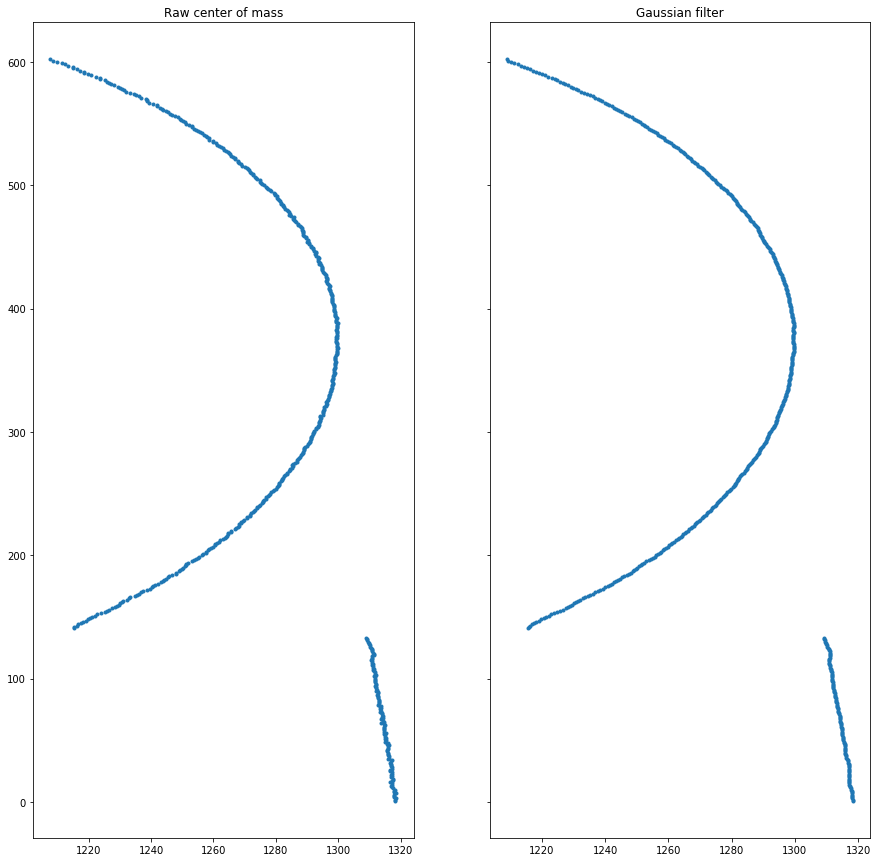

In [59]:
# Compare stripes

pylab.rcParams['figure.figsize'] = (15, 15)

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(u, h - v, '.')
ax1.set_title('Raw center of mass')
ax2.plot(f, h - v, '.')
ax2.set_title('Gaussian filter')
plt.show()

Total time: 0:00:00.054072


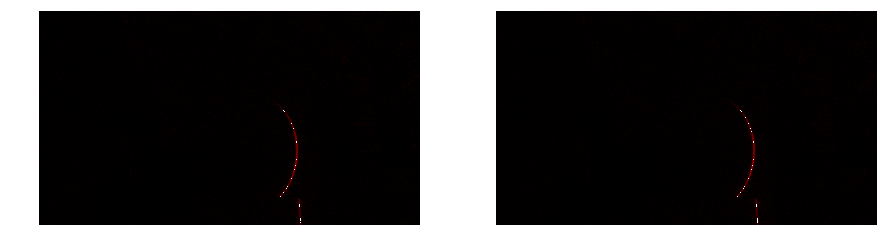

In [60]:


# Show images

image_line_cm = np.zeros_like(image_threshold)
image_line_gf = np.zeros_like(image_threshold)

image_line_cm[v, np.around(u).astype(int)] = 255
image_line_gf[v, np.around(f).astype(int)] = 255

image_cm = cv2.merge((cv2.add(image_diff_r, image_line_cm), image_line_cm, image_line_cm))
image_gf = cv2.merge((cv2.add(image_diff_r, image_line_gf), image_line_gf, image_line_gf))

total()

plot_images((image_cm, image_gf))

